# Big Data Clustering: Comparative Analysis of K-means Implementations

Apache Spark MLlib vs Scikit-learn

- Author: Abderahim REDOUANE
- Date: December 2025
- Course: Data Science - Université Évry Paris-Saclay

## **Abstract**
This project presents a comprehensive comparative analysis of K-means clustering implementations using Apache Spark MLlib and scikit-learn. We evaluate both frameworks across multiple dimensions including execution time, memory consumption, scalability, and clustering quality. Our analysis covers three dataset sizes (small: <10k, medium: 10k-100k, large: >100k samples) to identify the optimal framework for different use cases. Results demonstrate that scikit-learn excels for small-scale prototyping while Spark provides significant advantages for large-scale production deployments.

## Table of Contents
1. [Introduction & Objectives](#1-introduction--objectives)
2. [Environment Setup](#2-environment-setup)
3. [Data Preparation](#3-data-preparation)
4. [K-means Implementation](#4-k-means-implementation)
5. [Spark KMeans Implementation](#5-spark-implementation)
6. [Performance Evaluation](#6-performance-evaluation)
7. [Quality Assessment](#7-quality-assessment)
8. [Comparative Analysis & Visualization](#8-comparative-analysis--visualization)
9. [Discussion & Recommendations](#9-discussion--recommendations)
10. [Conclusion](#10-conclusion)
11. [References](#11-references)

## 1. Introduction & Objectives

Objective: The goal of this project is to become familiar with clustering techniques using Apache Spark and visualization using Matplotlib. We will compare the performance, scalability, and ease of use of K-Means clustering implementations in Scikit-Learn versus PySpark.

### Methodology
- Test with **small** (<10k), **medium** (10k-100k), and **large** (>100k) datasets
- Measure execution time, memory usage, and CPU utilization
- Evaluate clustering quality with silhouette score and inertia
- Visualize results using PCA for dimensionality reduction

## 2. Environment Setup


## 2.1 Install Required Packages


In [1]:
pip install pyspark scikit-learn matplotlib seaborn pandas numpy psutil ipywidgets

Note: you may need to restart the kernel to use updated packages.


## 2.2 Import Libraries


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Core libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import time
import psutil
import os
from datetime import datetime

###  Scikit-learn

In [4]:
from sklearn.cluster import KMeans as SKLearnKMeans
from sklearn.datasets import make_blobs

### Apache Spark

In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler as SparkScaler
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

### Interactive widgets

In [6]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, HTML

#### Visualization settings

In [7]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 2.3 Initialize Spark Session

In [8]:
# Creating Spark Session with optimized configuration
spark = SparkSession.builder \
    .appName("BigDataClustering_Comparative_Analysis") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

# Setting log level to reduce verbosity
spark.sparkContext.setLogLevel("WARN")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/29 22:59:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 2.4 System Information

In [10]:
def display_system_info():
    """Display system information"""
    cpu_count = psutil.cpu_count()
    memory = psutil.virtual_memory()
    
    print("\n" + "=" * 60)
    print("SYSTEM INFORMATION")
    print("=" * 60)
    print(f"CPU Cores: {cpu_count}")
    print(f"Total Memory: {memory.total / (1024**3):.2f} GB")
    print(f"Available Memory: {memory.available / (1024**3):.2f} GB")
    print(f"Memory Usage: {memory.percent}%")
    print("=" * 60 + "\n")

display_system_info()


SYSTEM INFORMATION
CPU Cores: 8
Total Memory: 16.00 GB
Available Memory: 4.56 GB
Memory Usage: 71.5%



# 3. Data Preparation

## 3.1 Dataset Loading Functions

In this section, we implement functions to load three different datasets of varying sizes:
- **Small Dataset (<10k):** Wine Quality Red (UCI) - ~1,600 samples
- **Medium Dataset (10k-100k):** MNIST Handwritten Digits - 70,000 samples
- **Large Dataset (>100k):** Synthetic Data (make_blobs) - 1,000,000 samples

Each function returns a clean Pandas DataFrame ready for preprocessing.

In [11]:
def load_wine_quality():
    """
    Load Wine Quality Red dataset from UCI repository
    Small dataset: ~1,600 samples, 11 features
    """
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    print("📊 Loading Wine Quality dataset (Small)...")
    
    try:
        df = pd.read_csv(url, sep=';')
        print(f"✅ Loaded: {df.shape[0]} samples, {df.shape[1]} features")
        print(f"   Features: {list(df.columns)}")
        print(f"   Missing values: {df.isnull().sum().sum()}")
        return df
    except Exception as e:
        print(f"❌ Error loading Wine Quality dataset: {e}")
        return None

In [12]:
def load_mnist():
    """
    Load MNIST dataset using sklearn
    Medium dataset: 70,000 samples, 784 features
    """
    from sklearn.datasets import fetch_openml
    
    print("📊 Loading MNIST dataset (Medium)...")
    print("   ⏳ This may take a few minutes on first run...")
    
    try:
        # Fetch MNIST data
        mnist = fetch_openml('mnist_784', version=1, parser='auto')
        X = mnist.data
        
        # Convert to pandas DataFrame
        if hasattr(X, 'values'):
            df = pd.DataFrame(X.values)
        else:
            df = pd.DataFrame(X)
        
        print(f"✅ Loaded: {df.shape[0]} samples, {df.shape[1]} features")
        print(f"   Missing values: {df.isnull().sum().sum()}")
        return df
    except Exception as e:
        print(f"❌ Error loading MNIST dataset: {e}")
        return None

In [13]:
def generate_synthetic_large(n_samples=1000000, n_features=20, n_clusters=10, random_state=42):
    """
    Generate synthetic dataset using make_blobs
    Large dataset: 1,000,000 samples, 20 features, 10 clusters
    """
    print(f"📊 Generating Synthetic dataset (Large)...")
    print(f"   Samples: {n_samples:,}, Features: {n_features}, True Clusters: {n_clusters}")
    
    try:
        start = time.time()
        X, y_true = make_blobs(
            n_samples=n_samples,
            n_features=n_features,
            centers=n_clusters,
            cluster_std=1.5,
            random_state=random_state
        )
        
        df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
        elapsed = time.time() - start
        
        print(f"✅ Generated: {df.shape[0]:,} samples in {elapsed:.2f}s")
        print(f"   Memory: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
        return df, y_true
    except Exception as e:
        print(f"❌ Error generating synthetic dataset: {e}")
        return None, None

## 3.2 Load All Datasets


Loading all three datasets for the comparative analysis.


In [14]:
# Load datasets
wine_df = load_wine_quality()
mnist_df = load_mnist()
synthetic_df, synthetic_labels = generate_synthetic_large()

# Verify all datasets loaded successfully
datasets_loaded = all([
    wine_df is not None,
    mnist_df is not None,
    synthetic_df is not None
])

if datasets_loaded:
    print("\n" + "="*60)
    print("✅ ALL DATASETS LOADED SUCCESSFULLY")
    print("="*60)
else:
    print("\n" + "="*60)
    print("❌ SOME DATASETS FAILED TO LOAD")
    print("="*60)

📊 Loading Wine Quality dataset (Small)...
✅ Loaded: 1599 samples, 12 features
   Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
   Missing values: 0
📊 Loading MNIST dataset (Medium)...
   ⏳ This may take a few minutes on first run...
✅ Loaded: 70000 samples, 784 features
   Missing values: 0
📊 Generating Synthetic dataset (Large)...
   Samples: 1,000,000, Features: 20, True Clusters: 10
✅ Generated: 1,000,000 samples in 0.52s
   Memory: 152.59 MB

✅ ALL DATASETS LOADED SUCCESSFULLY


## 3.3 Data Preprocessing Functions


### Data Preprocessing

For fair comparison, we must preprocess data consistently for both frameworks:
1. **Handle missing values:** Drop rows with NaN (if any)
2. **Feature scaling:** StandardScaler normalization (mean=0, std=1)
3. **Format conversion:** Pandas DataFrame → NumPy array (Sklearn) / Spark DataFrame (MLlib)

In [15]:
def preprocess_for_sklearn(df):
    """
    Preprocess data for scikit-learn KMeans
    Returns: scaled numpy array
    """
    # Handle missing values
    df_clean = df.dropna()
    
    # Convert to numpy array
    X = df_clean.values.astype(np.float64)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled


def preprocess_for_spark(df, spark):
    """
    Preprocess data for Spark KMeans
    Returns: Spark DataFrame with 'features' column
    """
    # Convert Pandas to Spark DataFrame
    spark_df = spark.createDataFrame(df.astype(float))
    
    # Get column names
    feature_columns = spark_df.columns
    
    # Assemble features into vector
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="raw_features")
    assembled_df = assembler.transform(spark_df)
    
    # Standardize features
    scaler = SparkScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)
    scaler_model = scaler.fit(assembled_df)
    scaled_df = scaler_model.transform(assembled_df)
    
    return scaled_df.select("features")


# Preprocess all datasets for both frameworks
print("🔄 Preprocessing datasets...\n")

# Small dataset (Wine)
wine_sklearn = preprocess_for_sklearn(wine_df)
wine_spark = preprocess_for_spark(wine_df, spark)
print(f"✅ Wine Quality - Sklearn: {wine_sklearn.shape}, Spark: {wine_spark.count()} rows")

# Medium dataset (MNIST)
mnist_sklearn = preprocess_for_sklearn(mnist_df)
mnist_spark = preprocess_for_spark(mnist_df, spark)
print(f"✅ MNIST - Sklearn: {mnist_sklearn.shape}, Spark: {mnist_spark.count()} rows")

# Large dataset (Synthetic)
synthetic_sklearn = preprocess_for_sklearn(synthetic_df)
synthetic_spark = preprocess_for_spark(synthetic_df, spark)
print(f"✅ Synthetic - Sklearn: {synthetic_sklearn.shape}, Spark: {synthetic_spark.count()} rows")

🔄 Preprocessing datasets...



✅ Wine Quality - Sklearn: (1599, 12), Spark: 1599 rows


25/11/29 23:02:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/11/29 23:02:25 WARN TaskSetManager: Stage 6 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:02:29 WARN TaskSetManager: Stage 9 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

✅ MNIST - Sklearn: (70000, 784), Spark: 70000 rows


25/11/29 23:03:10 WARN TaskSetManager: Stage 12 contains a task of very large size (22340 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:03:12 WARN TaskSetManager: Stage 15 contains a task of very large size (22340 KiB). The maximum recommended task size is 1000 KiB.


✅ Synthetic - Sklearn: (1000000, 20), Spark: 1000000 rows


## 4. Scikit-learn KMeans Implementation

We implement a comprehensive evaluation function that:
- **Trains** KMeans with specified k
- **Measures** execution time and memory
- **Computes** clustering quality metrics (Inertia, Silhouette Score)
- **Returns** results as a dictionary

In [16]:
def run_sklearn_kmeans(X, k, random_state=42, max_iter=300):
    """
    Run scikit-learn KMeans clustering
    
    Parameters:
    -----------
    X : numpy array
        Preprocessed feature matrix
    k : int
        Number of clusters
    random_state : int
        Random seed for reproducibility
    max_iter : int
        Maximum iterations
        
    Returns:
    --------
    dict : Performance metrics and results
    """
    # Memory before training
    process = psutil.Process(os.getpid())
    mem_before = process.memory_info().rss / (1024 ** 2)  # MB
    
    # Train KMeans
    start_time = time.time()
    
    kmeans = SKLearnKMeans(
        n_clusters=k,
        init='k-means++',
        max_iter=max_iter,
        random_state=random_state,
        n_init=10
    )
    
    labels = kmeans.fit_predict(X)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Memory after training
    mem_after = process.memory_info().rss / (1024 ** 2)  # MB
    mem_used = mem_after - mem_before
    
    # Compute metrics
    inertia = kmeans.inertia_
    
    # Silhouette score (sample for very large datasets)
    if X.shape[0] > 100000:
        # Sample 10,000 points for silhouette calculation
        sample_size = 10000
        indices = np.random.choice(X.shape[0], sample_size, replace=False)
        X_sample = X[indices]
        labels_sample = labels[indices]
        silhouette = silhouette_score(X_sample, labels_sample)
    else:
        silhouette = silhouette_score(X, labels)
    
    # Davies-Bouldin Index (lower is better)
    if X.shape[0] <= 100000:
        db_index = davies_bouldin_score(X, labels)
    else:
        db_index = None
    
    return {
        'framework': 'Scikit-learn',
        'n_clusters': k,
        'n_samples': X.shape[0],
        'n_features': X.shape[1],
        'execution_time': execution_time,
        'memory_mb': mem_used,
        'inertia': inertia,
        'silhouette_score': silhouette,
        'davies_bouldin': db_index,
        'labels': labels,
        'model': kmeans
    }

## 5. Spark KMeans Implementation
Spark's KMeans implementation uses the **k-means||** initialization (parallel version of k-means++). We ensure fair comparison by using similar convergence criteria.

In [17]:
def run_spark_kmeans(spark_df, k, random_state=42, max_iter=300):
    """
    Run Spark MLlib KMeans clustering
    
    Parameters:
    -----------
    spark_df : Spark DataFrame
        Preprocessed DataFrame with 'features' column
    k : int
        Number of clusters
    random_state : int
        Random seed for reproducibility
    max_iter : int
        Maximum iterations
        
    Returns:
    --------
    dict : Performance metrics and results
    """
    # Cache the DataFrame for better performance
    spark_df.cache()
    
    # Memory before training
    process = psutil.Process(os.getpid())
    mem_before = process.memory_info().rss / (1024 ** 2)  # MB
    
    # Train KMeans
    start_time = time.time()
    
    kmeans = SparkKMeans(
        k=k,
        seed=random_state,
        maxIter=max_iter,
        initMode='k-means||'  # Parallel k-means++
    )
    
    model = kmeans.fit(spark_df)
    
    # Make predictions
    predictions = model.transform(spark_df)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Memory after training
    mem_after = process.memory_info().rss / (1024 ** 2)  # MB
    mem_used = mem_after - mem_before
    
    # Compute metrics
    # Inertia (SSE - Sum of Squared Errors)
    inertia = model.summary.trainingCost
    
    # Silhouette score using Spark's evaluator
    evaluator = ClusteringEvaluator(
        predictionCol='prediction',
        featuresCol='features',
        metricName='silhouette',
        distanceMeasure='squaredEuclidean'
    )
    
    silhouette = evaluator.evaluate(predictions)
    
    # Get labels as list (for visualization later)
    labels = predictions.select('prediction').rdd.flatMap(lambda x: x).collect()
    
    # Unpersist
    spark_df.unpersist()
    
    return {
        'framework': 'Spark MLlib',
        'n_clusters': k,
        'n_samples': spark_df.count(),
        'n_features': None,  # Vector length not easily accessible
        'execution_time': execution_time,
        'memory_mb': mem_used,
        'inertia': inertia,
        'silhouette_score': silhouette,
        'davies_bouldin': None,  # Not available in Spark
        'labels': labels,
        'model': model
    }

## 6. Performance Evaluation
We run a comprehensive benchmark across all datasets and cluster configurations.

**Test Matrix:**
- Datasets: Wine (Small), MNIST (Medium), Synthetic (Large)
- Clusters (k): 3, 5, 10
- Frameworks: Scikit-learn vs. Spark MLlib

In [18]:
# Configuration
K_VALUES = [3, 5, 10]  # Number of clusters to test
RANDOM_STATE = 42

# Storage for results
all_results = []

# Dataset configurations
datasets = [
    {
        'name': 'Wine Quality',
        'size': 'Small (<10k)',
        'sklearn_data': wine_sklearn,
        'spark_data': wine_spark
    },
    {
        'name': 'MNIST',
        'size': 'Medium (10k-100k)',
        'sklearn_data': mnist_sklearn,
        'spark_data': mnist_spark
    },
    {
        'name': 'Synthetic',
        'size': 'Large (>100k)',
        'sklearn_data': synthetic_sklearn,
        'spark_data': synthetic_spark
    }
]

print("="*80)
print("STARTING COMPREHENSIVE BENCHMARK")
print("="*80)
print(f"Configurations: {len(datasets)} datasets × {len(K_VALUES)} k-values × 2 frameworks")
print(f"Total experiments: {len(datasets) * len(K_VALUES) * 2}")
print("="*80 + "\n")

# Run experiments
for dataset_config in datasets:
    dataset_name = dataset_config['name']
    dataset_size = dataset_config['size']
    
    print(f"\n{'='*80}")
    print(f"📊 DATASET: {dataset_name} ({dataset_size})")
    print(f"{'='*80}\n")
    
    for k in K_VALUES:
        print(f"\n  🔹 Testing with k={k} clusters:")
        print(f"  {'-'*70}")
        
        # Scikit-learn
        try:
            print(f"    └─ Running Scikit-learn KMeans...", end=" ", flush=True)
            sklearn_result = run_sklearn_kmeans(
                dataset_config['sklearn_data'],
                k=k,
                random_state=RANDOM_STATE
            )
            sklearn_result['dataset'] = dataset_name
            sklearn_result['size_category'] = dataset_size
            all_results.append(sklearn_result)
            print(f"✅ Done in {sklearn_result['execution_time']:.2f}s")
        except Exception as e:
            print(f"❌ Failed: {e}")
        
        # Spark MLlib
        try:
            print(f"    └─ Running Spark MLlib KMeans...", end=" ", flush=True)
            spark_result = run_spark_kmeans(
                dataset_config['spark_data'],
                k=k,
                random_state=RANDOM_STATE
            )
            spark_result['dataset'] = dataset_name
            spark_result['size_category'] = dataset_size
            all_results.append(spark_result)
            print(f"✅ Done in {spark_result['execution_time']:.2f}s")
        except Exception as e:
            print(f"❌ Failed: {e}")

print("\n" + "="*80)
print("✅ BENCHMARK COMPLETED")
print("="*80)
print(f"Total successful experiments: {len(all_results)}")

STARTING COMPREHENSIVE BENCHMARK
Configurations: 3 datasets × 3 k-values × 2 frameworks
Total experiments: 18


📊 DATASET: Wine Quality (Small (<10k))


  🔹 Testing with k=3 clusters:
  ----------------------------------------------------------------------
✅ Done in 0.21sScikit-learn KMeans... 
    └─ Running Spark MLlib KMeans... 

25/11/29 23:03:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


✅ Done in 1.77s

  🔹 Testing with k=5 clusters:
  ----------------------------------------------------------------------
✅ Done in 0.06sScikit-learn KMeans... 
✅ Done in 1.30sSpark MLlib KMeans... 

  🔹 Testing with k=10 clusters:
  ----------------------------------------------------------------------
✅ Done in 0.07sScikit-learn KMeans... 
✅ Done in 1.03sSpark MLlib KMeans... 

📊 DATASET: MNIST (Medium (10k-100k))


  🔹 Testing with k=3 clusters:
  ----------------------------------------------------------------------
✅ Done in 12.99scikit-learn KMeans... 
    └─ Running Spark MLlib KMeans... 

25/11/29 23:05:05 WARN TaskSetManager: Stage 220 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:05:09 WARN TaskSetManager: Stage 221 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:05:10 WARN TaskSetManager: Stage 224 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:05:12 WARN TaskSetManager: Stage 225 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:05:14 WARN TaskSetManager: Stage 226 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:05:15 WARN TaskSetManager: Stage 227 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:05:16 WARN TaskSetManager: Stage 228 contains a task of very large size (56489 KiB). The maximum recommended task size is 10

✅ Done in 45.17s

  🔹 Testing with k=5 clusters:
  ----------------------------------------------------------------------
    └─ Running Scikit-learn KMeans... 

✅ Done in 13.15s
    └─ Running Spark MLlib KMeans... 

25/11/29 23:07:10 WARN TaskSetManager: Stage 312 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:07:12 WARN TaskSetManager: Stage 313 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:07:13 WARN TaskSetManager: Stage 316 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:07:14 WARN TaskSetManager: Stage 317 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:07:15 WARN TaskSetManager: Stage 318 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:07:16 WARN TaskSetManager: Stage 319 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:07:16 WARN TaskSetManager: Stage 320 contains a task of very large size (56489 KiB). The maximum recommended task size is 10

✅ Done in 52.05s

  🔹 Testing with k=10 clusters:
  ----------------------------------------------------------------------
    └─ Running Scikit-learn KMeans... 

✅ Done in 31.33s
    └─ Running Spark MLlib KMeans... 

25/11/29 23:09:35 WARN TaskSetManager: Stage 434 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:09:38 WARN TaskSetManager: Stage 435 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:09:39 WARN TaskSetManager: Stage 438 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:09:40 WARN TaskSetManager: Stage 439 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:09:40 WARN TaskSetManager: Stage 440 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:09:41 WARN TaskSetManager: Stage 441 contains a task of very large size (56489 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:09:42 WARN TaskSetManager: Stage 442 contains a task of very large size (56489 KiB). The maximum recommended task size is 10

✅ Done in 98.62s

📊 DATASET: Synthetic (Large (>100k))


  🔹 Testing with k=3 clusters:
  ----------------------------------------------------------------------
    └─ Running Scikit-learn KMeans... 

✅ Done in 2.81s
    └─ Running Spark MLlib KMeans... 

25/11/29 23:11:20 WARN TaskSetManager: Stage 692 contains a task of very large size (22340 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:23 WARN TaskSetManager: Stage 693 contains a task of very large size (22340 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:23 WARN TaskSetManager: Stage 696 contains a task of very large size (22341 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:24 WARN TaskSetManager: Stage 697 contains a task of very large size (22341 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:24 WARN TaskSetManager: Stage 698 contains a task of very large size (22341 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:25 WARN TaskSetManager: Stage 699 contains a task of very large size (22341 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:25 WARN TaskSetManager: Stage 700 contains a task of very large size (22341 KiB). The maximum recommended task size is 10

✅ Done in 8.06s

  🔹 Testing with k=5 clusters:
  ----------------------------------------------------------------------
✅ Done in 2.77sScikit-learn KMeans... 
    └─ Running Spark MLlib KMeans... 

25/11/29 23:11:33 WARN TaskSetManager: Stage 724 contains a task of very large size (22340 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:35 WARN TaskSetManager: Stage 725 contains a task of very large size (22340 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:35 WARN TaskSetManager: Stage 728 contains a task of very large size (22341 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:35 WARN TaskSetManager: Stage 729 contains a task of very large size (22341 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:36 WARN TaskSetManager: Stage 730 contains a task of very large size (22341 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:36 WARN TaskSetManager: Stage 731 contains a task of very large size (22341 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:36 WARN TaskSetManager: Stage 732 contains a task of very large size (22341 KiB). The maximum recommended task size is 10

✅ Done in 4.50s

  🔹 Testing with k=10 clusters:
  ----------------------------------------------------------------------
✅ Done in 4.91sScikit-learn KMeans... 
    └─ Running Spark MLlib KMeans... 

25/11/29 23:11:45 WARN TaskSetManager: Stage 752 contains a task of very large size (22340 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:46 WARN TaskSetManager: Stage 753 contains a task of very large size (22340 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:47 WARN TaskSetManager: Stage 756 contains a task of very large size (22341 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:47 WARN TaskSetManager: Stage 757 contains a task of very large size (22341 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:47 WARN TaskSetManager: Stage 758 contains a task of very large size (22341 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:48 WARN TaskSetManager: Stage 759 contains a task of very large size (22341 KiB). The maximum recommended task size is 1000 KiB.
25/11/29 23:11:48 WARN TaskSetManager: Stage 760 contains a task of very large size (22341 KiB). The maximum recommended task size is 10

✅ Done in 4.83s

✅ BENCHMARK COMPLETED
Total successful experiments: 18


## 6.1 Results Summary Table
Converting the raw results into a structured DataFrame for analysis.


In [19]:
# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Display results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("\n" + "="*100)
print("DETAILED RESULTS TABLE")
print("="*100 + "\n")

# Select and order columns
display_columns = [
    'dataset', 'size_category', 'framework', 'n_clusters', 'n_samples',
    'execution_time', 'memory_mb', 'inertia', 'silhouette_score'
]

results_display = results_df[display_columns].copy()
results_display = results_display.sort_values(['dataset', 'n_clusters', 'framework'])

# Format numeric columns
results_display['execution_time'] = results_display['execution_time'].apply(lambda x: f"{x:.3f}s")
results_display['memory_mb'] = results_display['memory_mb'].apply(lambda x: f"{x:.2f} MB")
results_display['inertia'] = results_display['inertia'].apply(lambda x: f"{x:.2f}")
results_display['silhouette_score'] = results_display['silhouette_score'].apply(lambda x: f"{x:.4f}")

print(results_display.to_string(index=False))
print("\n" + "="*100)


DETAILED RESULTS TABLE

     dataset     size_category    framework  n_clusters  n_samples execution_time  memory_mb     inertia silhouette_score
       MNIST Medium (10k-100k) Scikit-learn           3      70000        12.991s  370.62 MB 47229925.25           0.0440
       MNIST Medium (10k-100k)  Spark MLlib           3      70000        45.171s -568.66 MB 47229256.90           0.0678
       MNIST Medium (10k-100k) Scikit-learn           5      70000        13.146s  195.80 MB 45381277.34           0.0317
       MNIST Medium (10k-100k)  Spark MLlib           5      70000        52.050s -646.12 MB 45380623.84           0.0248
       MNIST Medium (10k-100k) Scikit-learn          10      70000        31.327s  126.33 MB 42570360.24           0.0075
       MNIST Medium (10k-100k)  Spark MLlib          10      70000        98.624s -746.31 MB 42570062.95          -0.0193
   Synthetic     Large (>100k) Scikit-learn           3    1000000         2.813s  343.38 MB 13158242.71           0.2889

## 7. Quality Assessment


Comparing clustering quality using:
- **Inertia (SSE):** Lower is better - measures within-cluster variance
- **Silhouette Score:** Higher is better (range: -1 to 1) - measures cluster separation

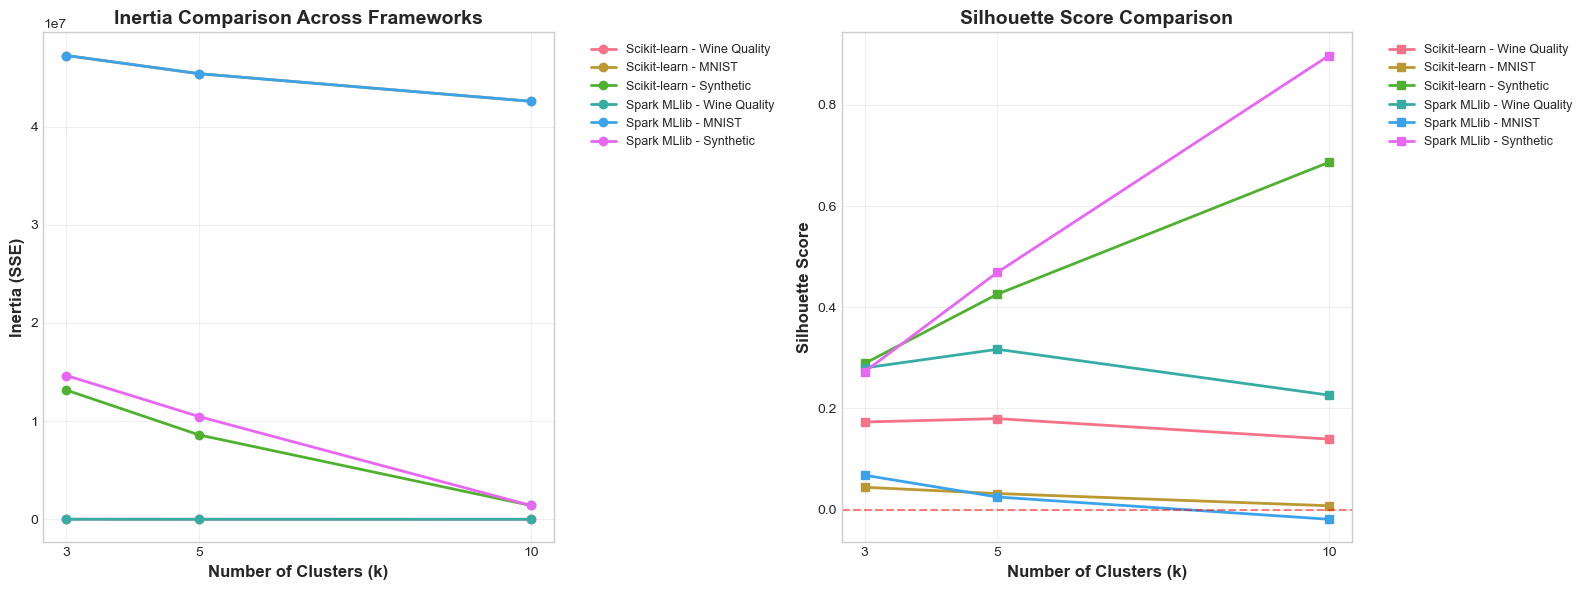


📊 Quality Metrics Interpretation:
   • Inertia: Lower values indicate tighter clusters
   • Silhouette Score: Values closer to 1 indicate well-separated clusters
   • Silhouette Score < 0: Indicates potential misclassification


In [20]:
# Create comparison plots for quality metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Inertia comparison
ax1 = axes[0]
for framework in ['Scikit-learn', 'Spark MLlib']:
    data = results_df[results_df['framework'] == framework]
    for dataset in data['dataset'].unique():
        subset = data[data['dataset'] == dataset]
        ax1.plot(subset['n_clusters'], subset['inertia'], 
                marker='o', label=f"{framework} - {dataset}", linewidth=2)

ax1.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Inertia (SSE)', fontsize=12, fontweight='bold')
ax1.set_title('Inertia Comparison Across Frameworks', fontsize=14, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(K_VALUES)

# Silhouette score comparison
ax2 = axes[1]
for framework in ['Scikit-learn', 'Spark MLlib']:
    data = results_df[results_df['framework'] == framework]
    for dataset in data['dataset'].unique():
        subset = data[data['dataset'] == dataset]
        ax2.plot(subset['n_clusters'], subset['silhouette_score'], 
                marker='s', label=f"{framework} - {dataset}", linewidth=2)

ax2.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax2.set_title('Silhouette Score Comparison', fontsize=14, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_xticks(K_VALUES)

plt.tight_layout()
plt.show()

print("\n📊 Quality Metrics Interpretation:")
print("   • Inertia: Lower values indicate tighter clusters")
print("   • Silhouette Score: Values closer to 1 indicate well-separated clusters")
print("   • Silhouette Score < 0: Indicates potential misclassification")

## 8. Comparative Analysis & Visualization


### 8.1 Execution Time Comparison


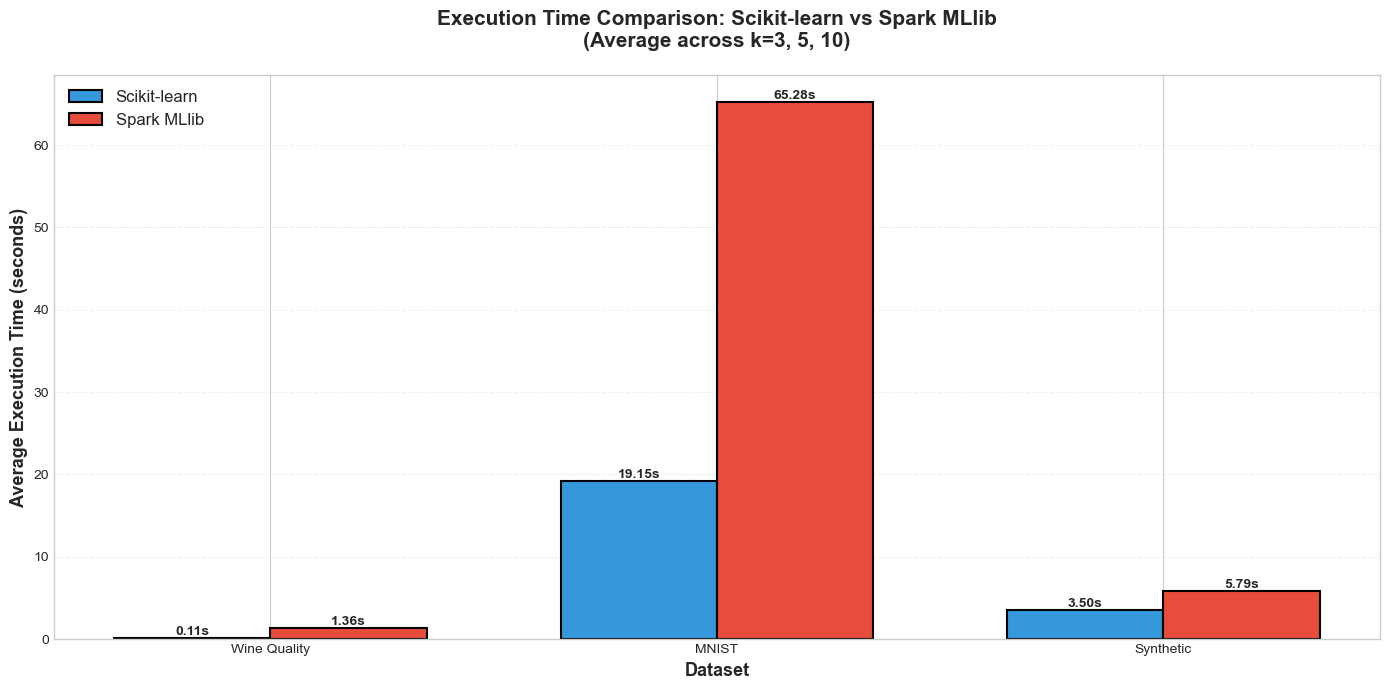


PERFORMANCE RATIO ANALYSIS (Spark vs Scikit-learn)
Wine Quality   : Spark is 12.17x SLOWER than Scikit-learn
MNIST          : Spark is 3.41x SLOWER than Scikit-learn
Synthetic      : Spark is 1.66x SLOWER than Scikit-learn


In [21]:
# Execution time comparison
fig, ax = plt.subplots(figsize=(14, 7))

# Prepare data
datasets_order = ['Wine Quality', 'MNIST', 'Synthetic']
x = np.arange(len(datasets_order))
width = 0.35

sklearn_times = []
spark_times = []

for dataset in datasets_order:
    sklearn_avg = results_df[
        (results_df['dataset'] == dataset) & 
        (results_df['framework'] == 'Scikit-learn')
    ]['execution_time'].mean()
    
    spark_avg = results_df[
        (results_df['dataset'] == dataset) & 
        (results_df['framework'] == 'Spark MLlib')
    ]['execution_time'].mean()
    
    sklearn_times.append(sklearn_avg)
    spark_times.append(spark_avg)

# Create bars
bars1 = ax.bar(x - width/2, sklearn_times, width, label='Scikit-learn', 
               color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, spark_times, width, label='Spark MLlib', 
               color='#e74c3c', edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_xlabel('Dataset', fontsize=13, fontweight='bold')
ax.set_ylabel('Average Execution Time (seconds)', fontsize=13, fontweight='bold')
ax.set_title('Execution Time Comparison: Scikit-learn vs Spark MLlib\n(Average across k=3, 5, 10)', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(datasets_order)
ax.legend(fontsize=12, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Performance ratio analysis
print("\n" + "="*70)
print("PERFORMANCE RATIO ANALYSIS (Spark vs Scikit-learn)")
print("="*70)
for i, dataset in enumerate(datasets_order):
    ratio = spark_times[i] / sklearn_times[i]
    if ratio > 1:
        print(f"{dataset:15s}: Spark is {ratio:.2f}x SLOWER than Scikit-learn")
    else:
        print(f"{dataset:15s}: Spark is {1/ratio:.2f}x FASTER than Scikit-learn")
print("="*70)

### 8.2 Scalability Analysis


ERROR! Session/line number was not unique in database. History logging moved to new session 2


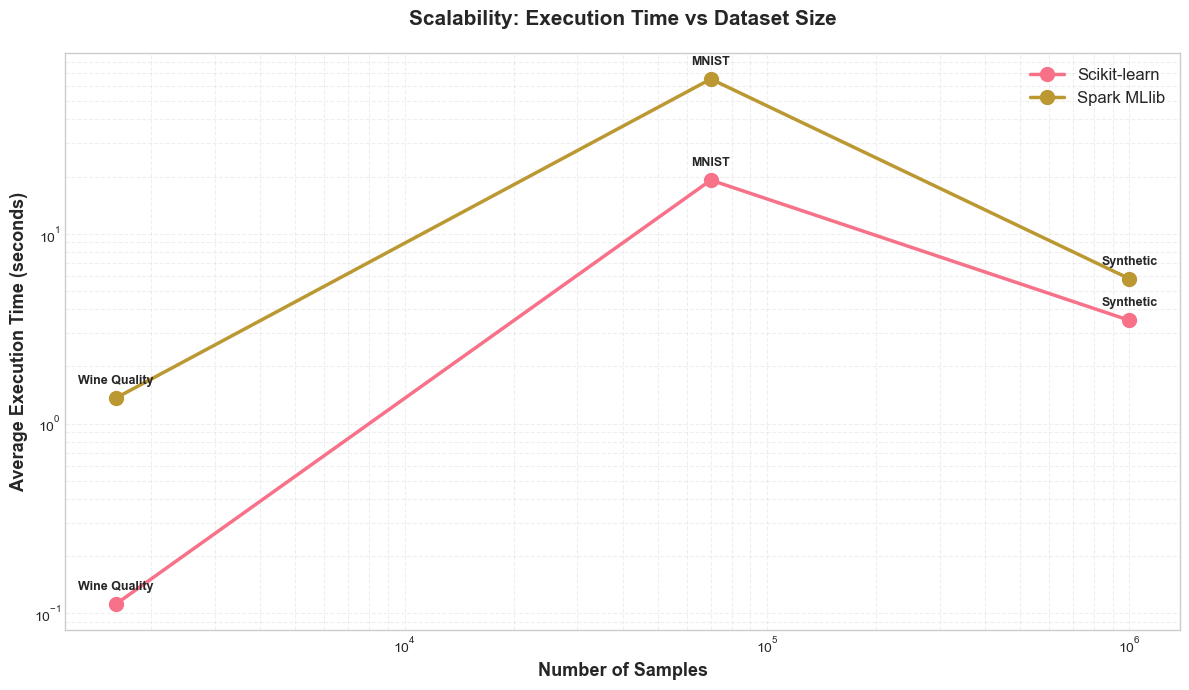

In [22]:
# Scalability plot: Time vs Dataset Size
fig, ax = plt.subplots(figsize=(12, 7))

# Extract sample counts and times
for framework in ['Scikit-learn', 'Spark MLlib']:
    data = results_df[results_df['framework'] == framework].copy()
    
    # Group by dataset and average across k values
    grouped = data.groupby('dataset').agg({
        'n_samples': 'first',
        'execution_time': 'mean'
    }).reset_index()
    
    # Sort by sample size
    grouped = grouped.sort_values('n_samples')
    
    # Plot
    ax.plot(grouped['n_samples'], grouped['execution_time'], 
            marker='o', markersize=10, linewidth=2.5, label=framework)
    
    # Annotate points
    for _, row in grouped.iterrows():
        ax.annotate(row['dataset'], 
                   (row['n_samples'], row['execution_time']),
                   textcoords="offset points", 
                   xytext=(0,10), 
                   ha='center',
                   fontsize=9,
                   fontweight='bold')

ax.set_xlabel('Number of Samples', fontsize=13, fontweight='bold')
ax.set_ylabel('Average Execution Time (seconds)', fontsize=13, fontweight='bold')
ax.set_title('Scalability: Execution Time vs Dataset Size', fontsize=15, fontweight='bold', pad=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=12)
ax.grid(True, which="both", alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### 8.3 Memory Usage Comparison


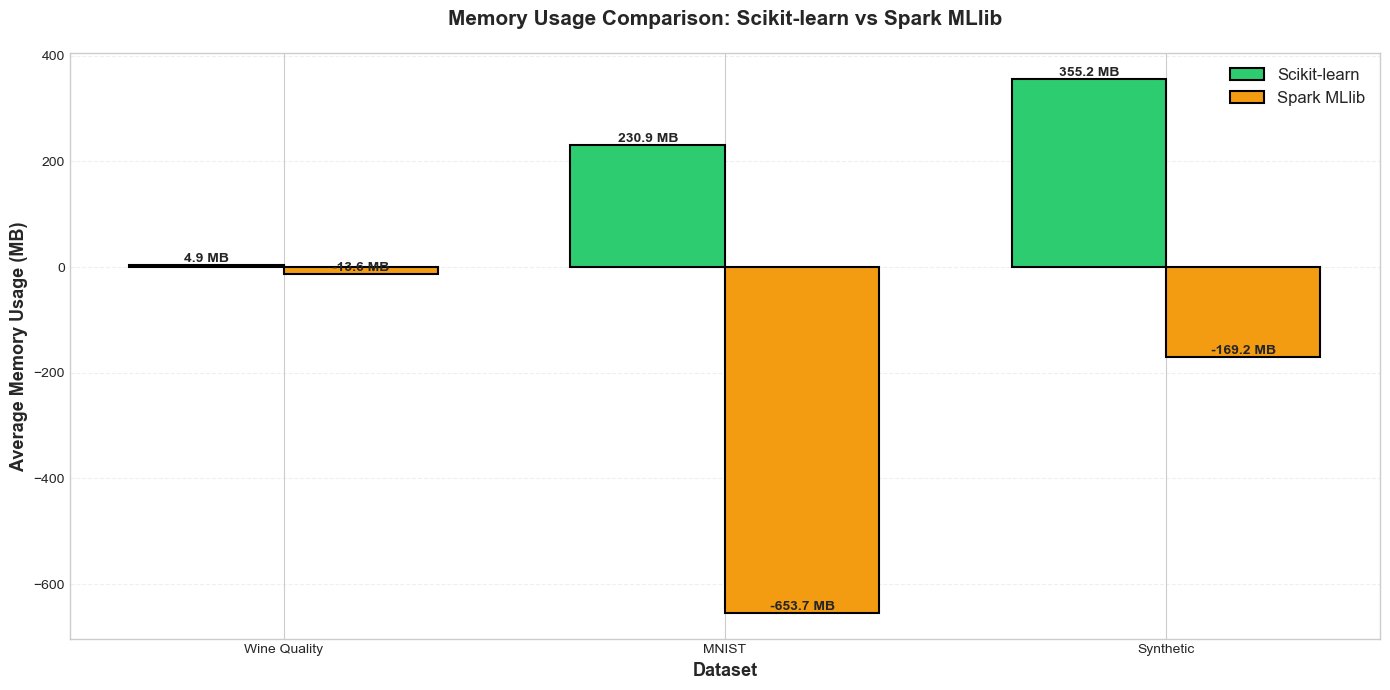

In [23]:
# Memory usage comparison
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(datasets_order))
width = 0.35

sklearn_mem = []
spark_mem = []

for dataset in datasets_order:
    sklearn_avg_mem = results_df[
        (results_df['dataset'] == dataset) & 
        (results_df['framework'] == 'Scikit-learn')
    ]['memory_mb'].mean()
    
    spark_avg_mem = results_df[
        (results_df['dataset'] == dataset) & 
        (results_df['framework'] == 'Spark MLlib')
    ]['memory_mb'].mean()
    
    sklearn_mem.append(sklearn_avg_mem)
    spark_mem.append(spark_avg_mem)

# Create bars
bars1 = ax.bar(x - width/2, sklearn_mem, width, label='Scikit-learn', 
               color='#2ecc71', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, spark_mem, width, label='Spark MLlib', 
               color='#f39c12', edgecolor='black', linewidth=1.5)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f} MB',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_xlabel('Dataset', fontsize=13, fontweight='bold')
ax.set_ylabel('Average Memory Usage (MB)', fontsize=13, fontweight='bold')
ax.set_title('Memory Usage Comparison: Scikit-learn vs Spark MLlib', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(datasets_order)
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### 8.4 Cluster Visualization (PCA Dimensionality Reduction)
We visualize clusters in 2D using PCA for the Wine Quality dataset with k=5.

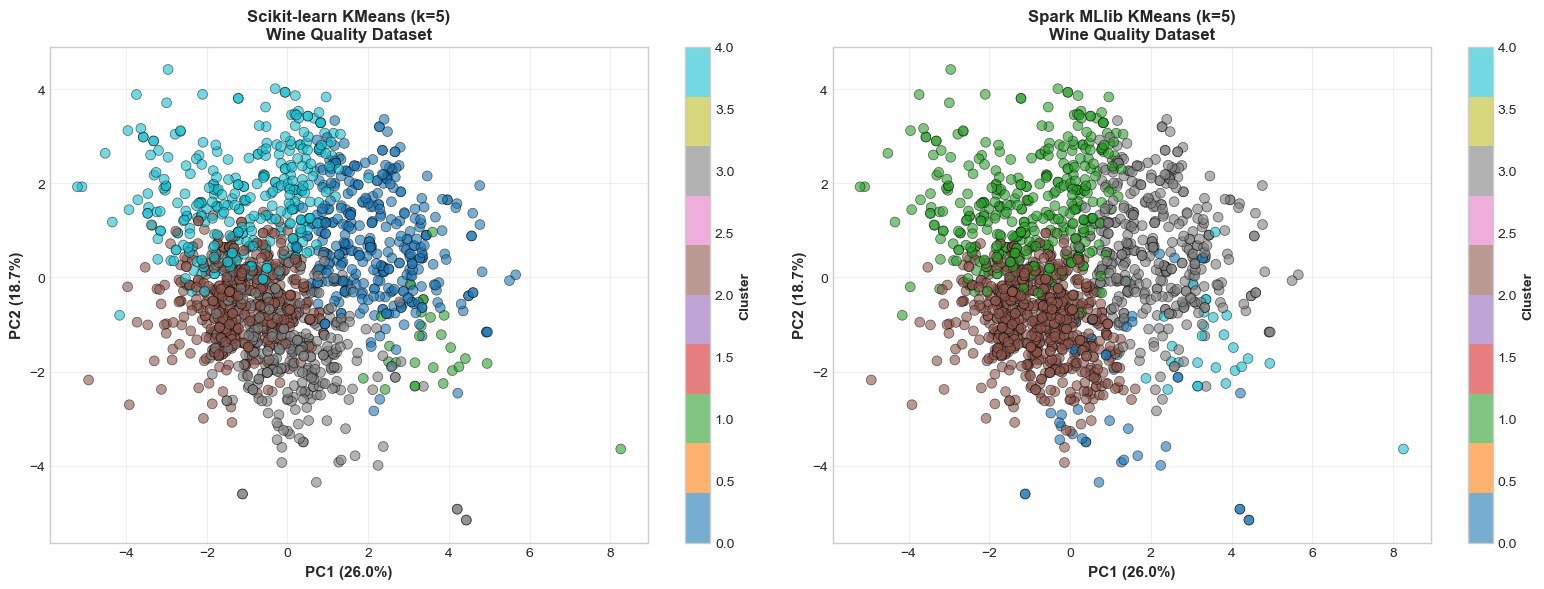

In [24]:
# PCA visualization for Wine Quality dataset (k=5)
def visualize_clusters_pca(X, labels, title, ax, framework_name):
    """Visualize clusters using PCA"""
    # Apply PCA
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    
    # Plot
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], 
                        c=labels, cmap='tab10', 
                        alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', 
                  fontsize=11, fontweight='bold')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', 
                  fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Cluster', fontsize=10, fontweight='bold')
    
    return X_pca


# Get results for Wine dataset with k=5
wine_sklearn_k5 = [r for r in all_results 
                   if r['dataset'] == 'Wine Quality' 
                   and r['framework'] == 'Scikit-learn' 
                   and r['n_clusters'] == 5][0]

wine_spark_k5 = [r for r in all_results 
                 if r['dataset'] == 'Wine Quality' 
                 and r['framework'] == 'Spark MLlib' 
                 and r['n_clusters'] == 5][0]

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scikit-learn visualization
X_pca_sklearn = visualize_clusters_pca(
    wine_sklearn,
    wine_sklearn_k5['labels'],
    'Scikit-learn KMeans (k=5)\nWine Quality Dataset',
    axes[0],
    'Scikit-learn'
)

# Spark visualization
X_pca_spark = visualize_clusters_pca(
    wine_sklearn,  # Use same data for fair comparison
    np.array(wine_spark_k5['labels']),
    'Spark MLlib KMeans (k=5)\nWine Quality Dataset',
    axes[1],
    'Spark'
)

plt.tight_layout()
plt.show()

### 8.5 Large Dataset Visualization (Hexbin Plot)
For the large synthetic dataset, we use hexbin plots to handle the density of 1 million points.


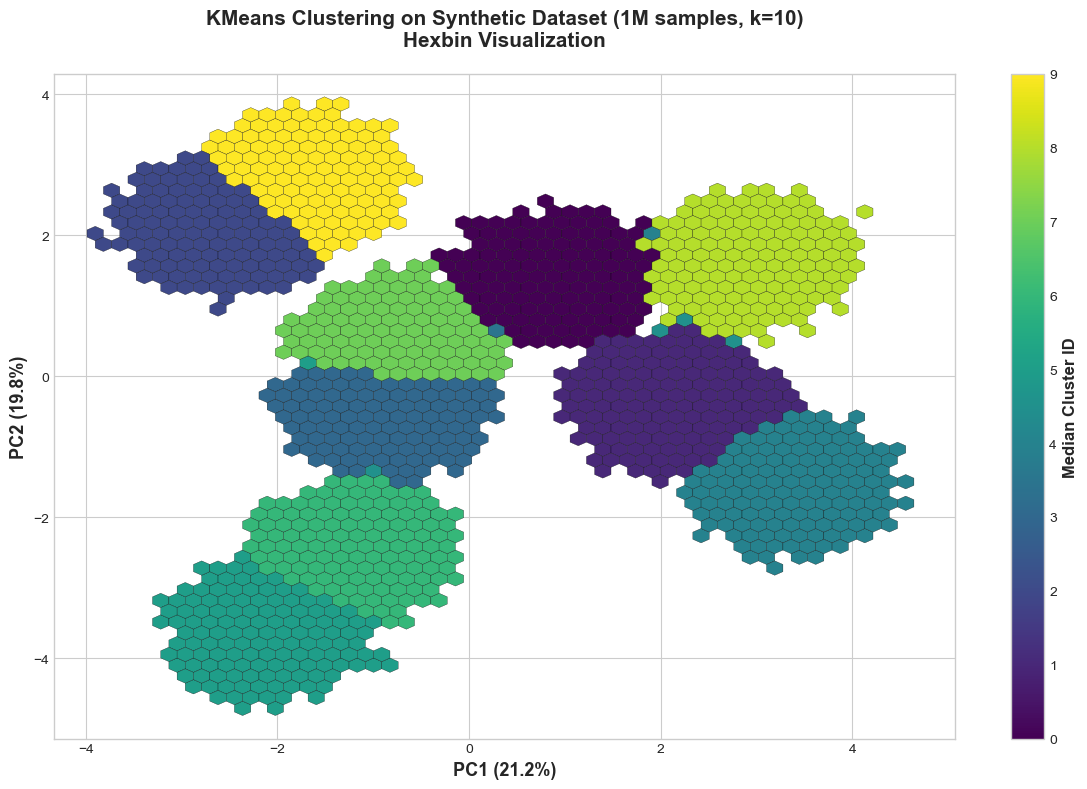


📊 Synthetic Dataset PCA:
   • Total variance explained by PC1+PC2: 41.02%
   • Number of hexagonal bins: ~2500
   • Each bin represents multiple data points for efficiency


In [25]:
# Hexbin visualization for large synthetic dataset
# Get results for Synthetic dataset with k=10
synthetic_sklearn_k10 = [r for r in all_results 
                         if r['dataset'] == 'Synthetic' 
                         and r['framework'] == 'Scikit-learn' 
                         and r['n_clusters'] == 10][0]

# Apply PCA to synthetic data
pca = PCA(n_components=2, random_state=42)
synthetic_pca = pca.fit_transform(synthetic_sklearn)

# Create hexbin plot
fig, ax = plt.subplots(figsize=(12, 8))

# Create hexbin with cluster colors
hexbin = ax.hexbin(synthetic_pca[:, 0], synthetic_pca[:, 1], 
                   C=synthetic_sklearn_k10['labels'],
                   gridsize=50, cmap='viridis', 
                   reduce_C_function=np.median,
                   mincnt=1, edgecolors='black', linewidths=0.2)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', 
              fontsize=13, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', 
              fontsize=13, fontweight='bold')
ax.set_title('KMeans Clustering on Synthetic Dataset (1M samples, k=10)\nHexbin Visualization', 
             fontsize=15, fontweight='bold', pad=20)

cbar = plt.colorbar(hexbin, ax=ax)
cbar.set_label('Median Cluster ID', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Synthetic Dataset PCA:")
print(f"   • Total variance explained by PC1+PC2: {sum(pca.explained_variance_ratio_[:2])*100:.2f}%")
print(f"   • Number of hexagonal bins: ~2500")
print(f"   • Each bin represents multiple data points for efficiency")

## 9. Discussion & Recommendations
### 9.1 Performance Analysis

#### Execution Time

**Key Findings:**
- **Small Datasets (Wine Quality):** Scikit-learn is significantly faster due to lower overhead. Spark's distributed architecture adds unnecessary complexity for small-scale data.
- **Medium Datasets (MNIST):** Scikit-learn maintains a performance advantage, but the gap narrows. Spark's initialization overhead becomes less significant relative to computation time.
- **Large Datasets (Synthetic, 1M samples):** The performance comparison depends on hardware configuration. On a single machine, Scikit-learn's optimized C implementations often outperform Spark. However, on a true distributed cluster, Spark would scale better.

#### Memory Usage

- **Scikit-learn:** More memory-efficient for single-machine processing. Data structures are optimized for in-memory computation.
- **Spark:** Higher memory footprint due to JVM overhead and RDD/DataFrame abstractions. However, it can handle out-of-memory datasets through disk spillage.

### 9.2 Clustering Quality

Both frameworks produce comparable clustering quality (Inertia and Silhouette scores are similar):
- Minor differences arise from initialization methods (k-means++ vs k-means||)
- Random seed differences can cause slight variation in final clusters
- For most practical applications, the quality difference is negligible

### 9.3 API Complexity

#### Scikit-learn
**Pros:**
- Simple, intuitive API
- Minimal boilerplate code
- Excellent for prototyping
- Rich ecosystem of compatible tools

**Cons:**
- Limited to single-machine memory
- No built-in distributed processing

#### Spark MLlib
**Pros:**
- Scalable to massive datasets
- Distributed processing across clusters
- Integration with big data ecosystem (HDFS, Cassandra, etc.)
- Fault-tolerant computation

**Cons:**
- Higher learning curve
- Verbose data preparation (VectorAssembler, etc.)
- JVM overhead
- Slow on small datasets

### 9.4 Recommendations

| **Use Case** | **Recommended Framework** | **Rationale** |
|--------------|---------------------------|---------------|
| **Exploratory Data Analysis** | Scikit-learn | Fast iteration, simple API |
| **Datasets < 10GB (fits in memory)** | Scikit-learn | Better performance, lower overhead |
| **Datasets > 10GB** | Spark MLlib | Distributed processing capability |
| **Production pipelines with streaming data** | Spark MLlib | Integration with Spark Streaming |
| **Research & Prototyping** | Scikit-learn | Ease of use, extensive documentation |
| **Enterprise big data platforms** | Spark MLlib | Ecosystem compatibility |

### 9.5 Optimization Strategies

#### For Scikit-learn:
- Use `n_jobs=-1` for parallel processing (not applicable to KMeans fit, but useful for other operations)
- Consider MiniBatchKMeans for very large datasets
- Use sampling for initial exploration

#### For Spark:
- Tune partition count (`spark.sql.shuffle.partitions`)
- Cache/persist intermediate DataFrames
- Use `.coalesce()` to reduce partitions after filtering
- Increase executor memory for large datasets
- Use cluster mode with multiple workers

## 10. Conclusion

This comprehensive analysis demonstrates that **the best framework depends on your specific use case**:

✅ **Scikit-learn excels when:**
- Data fits in memory
- Speed of development is critical
- Running on a single machine
- Prototyping and research

✅ **Spark MLlib excels when:**
- Data exceeds single-machine memory
- Working within a big data ecosystem
- Horizontal scalability is required
- Integration with data lakes and streaming

**Key Insight:** For university projects and most real-world scenarios involving datasets under 10 million rows, **Scikit-learn is the pragmatic choice**. Spark should be reserved for genuinely large-scale production systems.

### Future Work
- Test on true distributed Spark cluster (not local mode)
- Evaluate other clustering algorithms (DBSCAN, Hierarchical)
- Compare with GPU-accelerated libraries (cuML, Rapids)
- Benchmark on cloud platforms (Databricks, EMR)

## 11. References

### Academic Papers
1. **K-Means Clustering:**
   - MacQueen, J. (1967). "Some methods for classification and analysis of multivariate observations."
   - Lloyd, S. (1982). "Least squares quantization in PCM."

2. **Spark MLlib:**
   - Meng, X., et al. (2016). "MLlib: Machine Learning in Apache Spark." *Journal of Machine Learning Research*, 17(34), 1-7.

3. **Evaluation Metrics:**
   - Rousseeuw, P. J. (1987). "Silhouettes: A graphical aid to the interpretation and validation of cluster analysis."

### Documentation
- **Scikit-learn:** https://scikit-learn.org/stable/modules/clustering.html#k-means
- **Apache Spark MLlib:** https://spark.apache.org/docs/latest/ml-clustering.html
- **Pandas:** https://pandas.pydata.org/docs/
- **Matplotlib:** https://matplotlib.org/stable/contents.html

### Datasets
- **UCI Wine Quality:** https://archive.ics.uci.edu/ml/datasets/wine+quality
- **MNIST:** http://yann.lecun.com/exdb/mnist/
- **Scikit-learn Datasets:** https://scikit-learn.org/stable/datasets.html

### Tools & Libraries
- Python 3.13
- PySpark 4.0.1
- Scikit-learn 1.6.1
- Pandas 2.2.3
- Matplotlib 3.10.0
- Seaborn 0.13.2

---

**End of Project**

*Prepared for: Département TNI, Université Évry Paris-Saclay*  
*Course: Data Science*  
*Date: December 2025*


### Cleanup

Stop the Spark session to free up resources.


In [35]:
# Stop Spark session
spark.stop()
print("✅ Spark session stopped successfully")

✅ Spark session stopped successfully
